# CV_Project_5

### Задача:
Сравнить позы двух людей на видео

In [1]:
#Загрузка библиотек
import torch
import torchvision
from torchvision import transforms as T
import cv2
import os
import glob
import matplotlib.pyplot as plt
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from torchvision.io import read_image
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### Модель Keypoint RCNN

Для создания каркаса позы человека будем использовать Keypoint RCNN, имплементация которой представлена в библиотеке torchvision.

Модель обучена на наборе данных MS-COCO (Common Objects in Context) с целью обнаружения 17 ключевых точек человеческого тела (нос, глаза, уши, плечи, локти, запястья, бёдра, колени и лодыжки).

Модель выводит список из следующих элементов:

- boxes — тензор размера [N, 4], где N — количество обнаруженных объектов.
- labels — тензор размера [N], класс объекта. Он всегда равен 1, так как каждый обнаруженный «ящик» указывает на человека. 0 обозначает фоновый класс.
- scores — тензор размера [N], отображающий показатель достоверности обнаруженного объекта.
- keypoints — тензор размера [N, 17, 3], отображающий 17 ключевых точек N человек. Первые два числа — координаты x и y, а третье — видимость.
- keypoints_scores — тензор размера [N, 17], отражающий оценку всех ключевых точек для каждого обнаруженного человека.

Keypoint RCNN имеет готовую реализацию в обёртке PyTorch. С помощью данной модели мы без труда детектируем ключевые точки человеческого тела (от глаз до лодыжек) на изображении, а также получаем степень достоверности этих обнаружений.

In [2]:
#Загружаем предобученную модель
model = keypointrcnn_resnet50_fpn(pretrained=True)
model = model.eval()

### Загрузка видео

Любое идео представляет из себя набор кадров, которые попарно и будем сравнивать. Для начала разберём каждый видеофрагмент на отдельные кадры

In [7]:
#Создаём директорию для кадров из видео
path = 'Image_sequence/work' #etalon для эталонного видео
if not os.path.exists(path):
    os.mkdir(path)

count = 0 #счётчик для кадров
videoFile = "VIDEO_5.mp4"
cap = cv2.VideoCapture(videoFile) #загрузка видео

frame_width = int(cap.get(3)) #ширина кадра 
frame_height = int(cap.get(4)) #высота кадра
fps = int(cap.get(5)) #количество кадров в секунду 

frame_size = (frame_width,frame_height) #размер кадра

while(cap.isOpened()):
    frameId = cap.get(1) #номер текущего кадра
    ret, frame = cap.read()
    
    if ret == True:
        
        filename = 'Image_sequence/work/frame{0:04d}.jpg'.format(count)
        cv2.imwrite(filename, frame)
        count += 1
        
    else:
        break
        
cap.release()

В качестве идеи для видео выбран самый простой подъём гантели на бицепс, ничего сложного: ноги на ширине плеч, спина ровная, на выдохе медленно сгибаем локтевой сустав и смотрим на результат...

In [8]:
path = 'Image_sequence/'

#Загрузим изображение
image = cv2.imread(path + 'etalon/frame0000.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

image_1 = cv2.imread(path +'work/frame0000.jpg')
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
image_1 = cv2.rotate(image_1, cv2.ROTATE_90_CLOCKWISE)

Как показала практика, модель прекрасно работает если объект в кадре находится в вертикальном положении. В противном случае иногда "теряет" ноги. Поэтому при загрузке изображений была использована конструкция cv2.rotate.

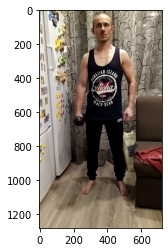

In [5]:
#Первый пошёл
plt.imshow(image)

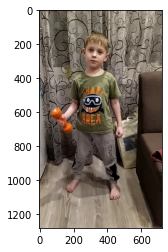

In [9]:
#Второй следом
plt.imshow(image_1)

In [10]:
#Переводим изображения в тензор
tr_image = torchvision.transforms.Compose([T.ToTensor()])

img = tr_image(image).cuda()
img_1 = tr_image(image_1).cuda()

#Для расчётов используем видеокарту
model.cuda()

#Прогоняем изображения через модель
with torch.no_grad():
    output_1 = model([img])
    output_2 = model([img_1])

In [14]:
#Выход модели
output_1

[{'boxes': tensor([[ 204.2204,    4.2356,  561.2731, 1106.6544],
          [ 444.8354,  206.0006,  570.4210, 1040.6527],
          [ 251.5438,  402.5766,  527.9135, 1085.0420],
          [ 233.8787,   17.5472,  555.6513,  571.4459],
          [ 385.7497,  594.6067,  544.9043, 1093.5599]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9994, 0.2079, 0.1615, 0.0794, 0.0786], device='cuda:0'),
  'keypoints': tensor([[[3.7171e+02, 1.1026e+02, 1.0000e+00],
           [3.9570e+02, 8.7229e+01, 1.0000e+00],
           [3.4963e+02, 8.9148e+01, 1.0000e+00],
           [4.2834e+02, 1.1313e+02, 1.0000e+00],
           [3.2084e+02, 1.2273e+02, 1.0000e+00],
           [4.8497e+02, 2.6281e+02, 1.0000e+00],
           [2.7957e+02, 2.8200e+02, 1.0000e+00],
           [5.4256e+02, 4.1920e+02, 1.0000e+00],
           [2.5461e+02, 4.3839e+02, 1.0000e+00],
           [5.3584e+02, 5.6024e+02, 1.0000e+00],
           [2.3158e+02, 5.7847e+02, 1.0000e+00],
       

In [15]:
#Отрисуем ключевые точки на исходном изображении
def draw_keypoints_per_person(img, all_keypoints, all_scores,
                              confs, keypoint_threshold=2,
                              conf_threshold=0.9):
    # создаем спектр цветов
    cmap = plt.get_cmap('rainbow')
    # создаем копию изображений
    img_copy = img.copy()
    color_id = np.arange(1,255, 255//len(all_keypoints)).tolist()[::-1]
    # для каждого задетектированного человека
    for person_id in range(len(all_keypoints)):
      # проверяем степень уверенности детектора
      if confs[person_id]>conf_threshold:
        # собираем опорные точки конкретного человека
        keypoints = all_keypoints[person_id, ...]
        # собираем скоры для опорных точек
        scores = all_scores[person_id, ...]
        #итерируем по каждому скору
        for kp in range(len(scores)):
            # проверяем степень уверенности детектора опорной точки
            if scores[kp]>keypoint_threshold:
                # конвертируем массив опорных точек в список целых чисел
                keypoint = tuple(map(
                    int, keypoints[kp, :2].detach().cpu().numpy().tolist()))
                # выбираем цвет
                color = tuple(np.asarray(cmap(color_id[person_id])[:-1])*255)
                # рисуем кружок радиуса 5 вокруг точки
                cv2.circle(img_copy, keypoint, 5, color, -1)

    return plt.imshow(img_copy)

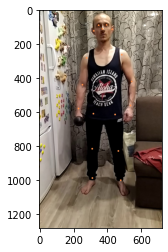

In [19]:
#Первый пошёл
draw_keypoints_per_person(image,
                         output_1[0]['keypoints'],
                         output_1[0]['keypoints_scores'],
                         output_1[0]['scores'],
                         keypoint_threshold=2,
                         conf_threshold=0.9)

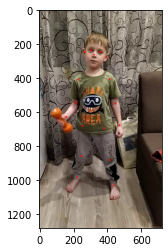

In [20]:
#Второй следом
draw_keypoints_per_person(image_1,
                         output_2[0]['keypoints'],
                         output_2[0]['keypoints_scores'],
                         output_2[0]['scores'],
                         keypoint_threshold=2,
                         conf_threshold=0.9)

А теперь соеденим ключевые точки на изображении для построения каркаса позы человека.

In [21]:
#Список опорных точек
keypoints = ['nose','left_eye','right_eye',
             'left_ear','right_ear','left_shoulder',
             'right_shoulder','left_elbow','right_elbow',
             'left_wrist','right_wrist','left_hip',
             'right_hip','left_knee', 'right_knee',
             'left_ankle','right_ankle']

def get_limbs_from_keypoints(keypoints):
    limbs = [
        [keypoints.index("right_eye"), keypoints.index("nose")],
        [keypoints.index("right_eye"), keypoints.index("right_ear")],
        [keypoints.index("left_eye"), keypoints.index("nose")],
        [keypoints.index("left_eye"), keypoints.index("left_ear")],
        [keypoints.index("right_shoulder"), keypoints.index("right_elbow")],
        [keypoints.index("right_elbow"), keypoints.index("right_wrist")],
        [keypoints.index("left_shoulder"), keypoints.index("left_elbow")],
        [keypoints.index("left_elbow"), keypoints.index("left_wrist")],
        [keypoints.index("right_hip"), keypoints.index("right_knee")],
        [keypoints.index("right_knee"), keypoints.index("right_ankle")],
        [keypoints.index("left_hip"), keypoints.index("left_knee")],
        [keypoints.index("left_knee"), keypoints.index("left_ankle")],
        [keypoints.index("right_shoulder"), keypoints.index("left_shoulder")],
        [keypoints.index("right_hip"), keypoints.index("left_hip")],
        [keypoints.index("right_shoulder"), keypoints.index("right_hip")],
        [keypoints.index("left_shoulder"), keypoints.index("left_hip")],
    ]
    return limbs


limbs = get_limbs_from_keypoints(keypoints)

In [26]:
def draw_skeleton_per_person(img, all_keypoints, all_scores,
                             confs, keypoint_threshold=2,
                             conf_threshold=0.9):
    
    cmap = plt.get_cmap('rainbow')
    img_copy = img.copy()
    if len(all_keypoints)>0:
      colors = np.arange(1,255, 255//len(all_keypoints)).tolist()[::-1]
      for person_id in range(len(all_keypoints)):
          if confs[person_id]>conf_threshold:
            keypoints = all_keypoints[person_id, ...]

    
            for limb_id in range(len(limbs)):
              # выберите первоначальную точку конечности 1
              limb_loc1 = keypoints[
            limbs[limb_id][0], :2].detach().cpu().numpy().astype(np.int32)
            
              # выберите первоначальную точку конечности 2
              limb_loc2 = keypoints[
            limbs[limb_id][1], :2].detach().cpu().numpy().astype(np.int32)
            
              # рассматривайте оценку уверенности конечностей как
              # минимальную оценку ключевой точки среди двух оценок
              # ключевых точек
              limb_score = min(
            all_scores[person_id, limbs[limb_id][0]],
            all_scores[person_id, limbs[limb_id][1]])
            
              # проверяем, если скор конечностей превосходит порог
              if limb_score> keypoint_threshold:
                color = tuple(
                    np.asarray(cmap(colors[person_id])[:-1])*255)
                
                # рисуем линию шириной 3
                cv2.line(img_copy, tuple(limb_loc1),
                         tuple(limb_loc2), color, 5)

    return plt.imshow(img_copy)


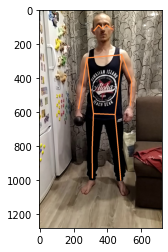

In [27]:
#Первый пошёл
draw_skeleton_per_person(image,
                         output_1[0]['keypoints'],
                         output_1[0]['keypoints_scores'],
                         output_1[0]['scores'],
                         keypoint_threshold=2,
                         conf_threshold=0.9)

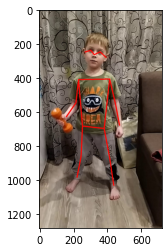

In [28]:
#Второй следом
draw_skeleton_per_person(image_1,
                         output_2[0]['keypoints'],
                         output_2[0]['keypoints_scores'],
                         output_2[0]['scores'],
                         keypoint_threshold=2,
                         conf_threshold=0.9)

In [36]:
#Соберём координаты ключевых точек для каждого из изображений 
output_1_list = []
for kp in range(len(output_1[0]['keypoints'][0])):
    output_1_list.append(
        output_1[0]['keypoints'][0][kp, :2].detach().cpu().numpy())
    
matrix_1 = np.array(output_1_list)    

output_2_list = []
for kp in range(len(output_2[0]['keypoints'][0])):
    output_2_list.append(
        output_2[0]['keypoints'][0][kp, :2].detach().cpu().numpy())
    
matrix_2 = np.array(output_2_list)

print('Матрица 1:', '\n', matrix_1, '\n',
      'Матрица 2:', '\n', matrix_2)

Матрица 1: 
 [[371.7088  110.25588]
 [395.70425  87.22887]
 [349.63297  89.14778]
 [428.33813 113.13426]
 [320.83835 122.72886]
 [484.96744 262.80994]
 [279.56613 281.9991 ]
 [542.5566  419.20178]
 [254.61087 438.39096]
 [535.8378  560.2423 ]
 [231.5752  578.47205]
 [445.61487 613.0126 ]
 [318.91873 608.2153 ]
 [464.81125 827.93146]
 [311.24017 814.499  ]
 [478.24872 999.67474]
 [312.2     986.24225]] 
 Матрица 2: 
 [[ 323.85184  262.16876]
 [ 357.47684  245.85173]
 [ 303.67682  236.25351]
 [ 392.06256  278.48575]
 [ 269.09106  246.81155]
 [ 413.1983   405.18243]
 [ 231.62318  408.06192]
 [ 447.78406  549.15594]
 [ 216.25175  544.3568 ]
 [ 471.8019   676.81244]
 [ 159.56958  627.8615 ]
 [ 381.49472  695.04913]
 [ 254.68034  681.6116 ]
 [ 415.11975  880.29504]
 [ 246.03392  858.21906]
 [ 437.2162  1029.0676 ]
 [ 222.97676  982.99615]]


У нас есть два набора ключевых точек:

- Модельный набор (который нужно имитировать).
- Ввод (необходимо сопоставить его с модельным набором).

При этом у объектов на кадрах могут быть разные размеры, располагаться они могут в разных местах и наклон камеры никто не отменял.

Следовательно, нам необходима комбинация переноса, масштабирования и поворота, которая лучше всего преобразует исходную позу в позу модели. В линейной алгебре такая комбинация представлена аффинным преобразованием.

Свойства аффинного преобразования:

- линии сопоставляются с линиями;
- параллельные линии остаются параллельными;
- исходный вектор не обязательно отображается в исходный;
- соотношения сохраняются.

### Применение аффинного преобразования к входному изображению

Аффинное отображение (преобразование) f() входного вектора x в модельный вектор y выглядит следующим образом:

y = f(x) = Ax + b

С помощью расширенной матрицы можно умножить вектор x на матрицу A и добавить вектора b за счёт единственного матричного умножения.

Эта расширенная матрица создаётся следующим образом:
1. Дополняем все векторы «1» в конце.
2. Дополняем матрицу строкой нулей внизу.
3. Дополняем матрицу столбцом (вектором переноса) справа и «1» в правом нижнем углу.

In [37]:
# Соберём два набора ключевых точек
model_key_points = matrix_1#[[x1,y2],[x2,y2],...]
input_key_points = matrix_2#[[x1,y2],[x2,y2],...]
 
# С помощью расширенной матрицы можно осуществить умножение вектора x на
# матрицу A и добавление вектора b за счёт единственного матричного 
# умножения.
# Расширенная матрица создаётся путём дополнения векторов "1" в конце.
pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
unpad = lambda x: x[:, :-1]
 
# Расширим наборы ключевых точек до [[ x y 1] , [x y 1]]
Y = pad(model_key_points)
X = pad(input_key_points)

In [39]:
# Решим задачу наименьших квадратов X * A = Y
# и найдём матрицу аффинного преобразования A.
A, res, rank, s = np.linalg.lstsq(X, Y)
A[np.abs(A) < 1e-10] = 0  # превратим в "0" слишком маленькие значения

# Теперь, когда мы нашли расширенную матрицу A,
# мы можем преобразовать входной набор ключевых точек
transform = lambda x: unpad(np.dot(pad(x), A))
input_transform = transform(input_key_points)
print(input_transform)

[[374.17227973 109.27240165]
 [407.16394495  84.23109049]
 [353.49507827  82.27833398]
 [442.31920324 116.62944341]
 [319.4069469  100.70920173]
 [466.44058417 262.05812586]
 [286.17961314 296.97806583]
 [504.34676582 425.48284145]
 [274.28088388 460.0417224 ]
 [531.35424159 571.54055305]
 [220.04990857 568.15469834]
 [442.11584372 608.68406675]
 [315.83759136 614.89236422]
 [480.08760594 820.84573739]
 [311.61384442 824.22879529]
 [505.70853842 992.08691414]
 [291.79742617 975.07276254]]


С помощью аффинного отображения мы получили преобразованный набор ключевых точек, необходимый для корректного сравнения позы спортсмена с модельной.

### Косинусное сходство и взвешенное совпадение

Теперь, когда у нас есть преобразованный вход X, мы можем сравнить его с позой модели. Для определения «сходства» X и y можно воспользоваться косинусным сходством и взвешенным совпадением с учётом показателей достоверности ключевых точек.

Косинусное сходство — это мера сходства между двумя векторами: в основном оно измеряет угол между ними и возвращает -1, если они прямо противоположны, и 1, если они абсолютно одинаковы. Важно отметить, что это мера ориентации, а не величины.

Взвешенное совпадение позволяет учесть степень достоверности ключевой точки: соединения с низкой достоверностью должны оказывать меньшее влияние на показатель совпадения, чем соединения с высокой степенью достоверности.

In [40]:
def cosine_distance(pose1, pose2):
    cossin = pose1.dot(np.transpose(pose2)) / (
        np.linalg.norm(pose1, axis=1) * np.linalg.norm(pose2, axis=1)
    )
    
    dist = np.diagonal(cossin).mean()

    return dist


def weight_distance(pose1, pose2, conf1):
    # D(U,V) = (1 / sum(conf1)) * sum(conf1 * ||pose1 - pose2||) = sum1 * sum2

    sum1 = 1 / np.sum(conf1)
    sum2 = 0

    for i in range(len(pose1)):
        # каждый индекс i имеет x и y, у которых одинаковая оценка достоверности
        conf_ind = math.floor(i / 2)
        sum2 = conf1[conf_ind] * abs(pose1[i] - pose2[i])

    weighted_dist = sum1 * sum2

    return weighted_dist

In [42]:
cosine_distance(matrix_1, input_transform)

0.9997578726846236

In [46]:
conf = np.array(output_1[0]['keypoints_scores'][0].detach().cpu().numpy())

weight_distance(matrix_1, input_transform, conf)

array([1.07852689, 0.59044432])

### Вывод

Благодаря алгоритмам сходства, таким как косинусное сходство и взвешенное совпадение, мы можем анализировать близость между двумя оценками позы человека. Сходство косинуса рассчитывается путём создания векторов поз и оценки косинуса угла между ними. Взвешенное совпадение учитывают оценку достоверности каждой отдельно найденной ключевой точки так, чтобы более реалистичные ключевые точки в большей степени влияли на результат.

Полная реализация покадрового сравнения двух видеофайлов приведена в скрипте main.py